# Adding time stamp

In [1]:
import datetime
print(f"This notebook was last run at : {datetime.datetime.now()}")

This notebook was last run at : 2024-06-08 01:59:27.432996


# Checking for GPU configuration in the PC

In [2]:
!nvidia-smi

Sat Jun  8 01:59:35 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Downloading the dataset (10% of the food_vision set)

In [3]:
# Get data (10% of labels)
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2024-06-08 01:59:49--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.96.207, 108.177.119.207, 108.177.127.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.96.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  31.1MB/s    in 6.0s    

2024-06-08 01:59:56 (26.7 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



# Exploring the folder structure and number of images per folder

In [4]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent

# Preparing the data and loading images into train_data and test_data buffers

In [5]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


# Creating tensorboard callback

In [6]:
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

# Importing TensorFlow and TensorFlow Hub

In [7]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

# Getting URLs of EfficientNetB0 (2019) and ResNetV250 (2016)

In [8]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# # New: EfficientNetB0 feature vector (version 2)
# efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

# Instantiating a Keras Sequential model with the TensorFlow Hub URLs.

In [9]:
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape

  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer
  ])

  return model

# Creating a model using ResNetV250 architecture as the feature extraction layer and compiling it

In [10]:
# Create model
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

# Adding callback to record performance of the model

In [11]:
# Fit the model
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=10,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20240608-020130
Epoch 1/10
24/24 [==============================] - 23s 585ms/step - loss: 1.7629 - accuracy: 0.4240 - val_loss: 1.1151 - val_accuracy: 0.6604
Epoch 2/10
24/24 [==============================] - 11s 479ms/step - loss: 0.8193 - accuracy: 0.7760 - val_loss: 0.8035 - val_accuracy: 0.7512
Epoch 3/10
24/24 [==============================] - 11s 453ms/step - loss: 0.5655 - accuracy: 0.8533 - val_loss: 0.7189 - val_accuracy: 0.7688
Epoch 4/10
24/24 [==============================] - 11s 453ms/step - loss: 0.4368 - accuracy: 0.8907 - val_loss: 0.7021 - val_accuracy: 0.7684
Epoch 5/10
24/24 [==============================] - 11s 479ms/step - loss: 0.3521 - accuracy: 0.9240 - val_loss: 0.6587 - val_accuracy: 0.7852
Epoch 6/10
24/24 [==============================] - 11s 452ms/step - loss: 0.2918 - accuracy: 0.9427 - val_loss: 0.6553 - val_accuracy: 0.7832
Epoch 7/10
24/24 [==============================] - 11s 479ms/step 

# Plotting loss and accuracy functions

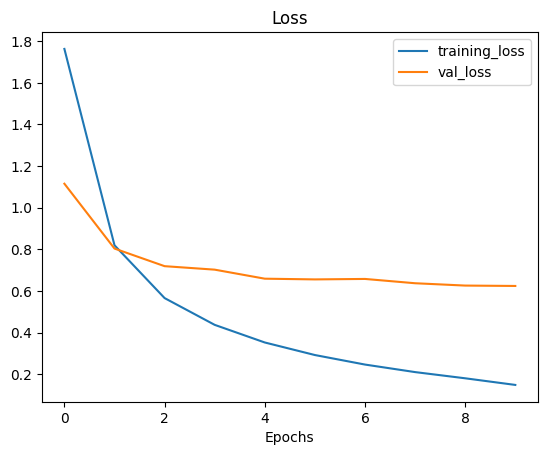

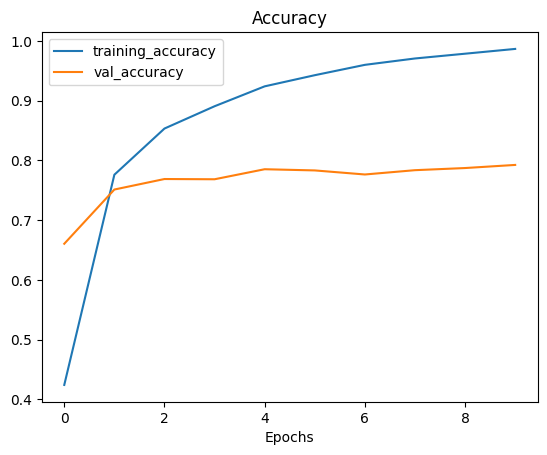

In [12]:
# If you wanted to, you could really turn this into a helper function to load in with a helper.py script...
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

plot_loss_curves(resnet_history)

# Summary of the model

In [13]:
# Resnet summary
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


# Predicting with new image

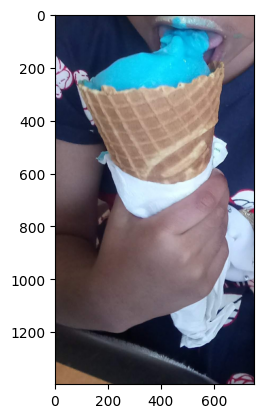

1/1 [==============================] - 2s 2s/step
Predictions: 
[[9.2757960e-05 2.2271986e-04 1.1444814e-03 7.4843234e-07 1.3375431e-03
  9.9655896e-01 4.8587026e-05 2.2202288e-05 2.5330708e-06 5.6933664e-04]]
Class Names: 
['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon', 'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi']

Predicted class:  ice_cream

Top three Probabilities
ice_cream 99.66 %,  hamburger 0.13 %,  fried_rice 0.11 %


In [14]:
from matplotlib.image import imread
from matplotlib import pyplot as plt

import os
import cv2
import numpy as np

image = imread('/content/icecream_4.png')
plt.imshow(image)
plt.show()

resized_image = cv2.resize(image, (224, 224))
reshaped = resized_image.reshape(1, 224, 224, 3)

prediction = resnet_model.predict(reshaped)
print("Predictions: ")
print(prediction)

#predicted_digit = np.argmax(prediction, axis = 1)
#print("Predicted digit:", predicted_digit[0])

class_names = list(test_data.class_indices.keys()) # Access class names from the ImageDataGenerator
print("Class Names: ")
print(class_names)

# Printing the predicted class for the input food item
print("")
print("Predicted class: ", class_names[np.argmax(prediction)])

# Identifying indices of top 3 matches
x_list = np.argsort(prediction)[::-1][:3]
#print("Indices:", x_list)
x = np.array(x_list)
len_x = 10  # numner of classes

max_1 = x[0][len_x-1]
max_2 = x[0][len_x-2]
max_3 = x[0][len_x-3]

# Printing top three probabilities
print("")
print("Top three Probabilities")
print(class_names[max_1], f"{(prediction[0][max_1]*100):.2f}", "%"  ", ", class_names[max_2],
 f"{(prediction[0][max_2]*100):.2f}", "%" ", ", class_names[max_3], f"{(prediction[0][max_3]*100):.2f}", "%")



# Creating a model using EfficientNetB0 architecture, compiling it, fitting it and adding callback

In [15]:
# Create model
efficientnet_model = create_model(model_url=efficientnet_url, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model
efficientnet_history = efficientnet_model.fit(train_data_10_percent, # only use 10% of training data
                                              epochs=10, # train for 5 epochs
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnetB0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20240608-020719
Epoch 1/10
24/24 [==============================] - 25s 575ms/step - loss: 1.8425 - accuracy: 0.4480 - val_loss: 1.2866 - val_accuracy: 0.7532
Epoch 2/10
24/24 [==============================] - 11s 468ms/step - loss: 1.0519 - accuracy: 0.7813 - val_loss: 0.8595 - val_accuracy: 0.8240
Epoch 3/10
24/24 [==============================] - 11s 465ms/step - loss: 0.7518 - accuracy: 0.8480 - val_loss: 0.6979 - val_accuracy: 0.8452
Epoch 4/10
24/24 [==============================] - 10s 439ms/step - loss: 0.6071 - accuracy: 0.8773 - val_loss: 0.6062 - val_accuracy: 0.8608
Epoch 5/10
24/24 [==============================] - 13s 541ms/step - loss: 0.5173 - accuracy: 0.8840 - val_loss: 0.5558 - val_accuracy: 0.8592
Epoch 6/10
24/24 [==============================] - 10s 445ms/step - loss: 0.4471 - accuracy: 0.9067 - val_loss: 0.5179 - val_accuracy: 0.8708
Epoch 7/10
24/24 [==============================] - 11s 466ms/s

# Plotting loss and accuracy functions

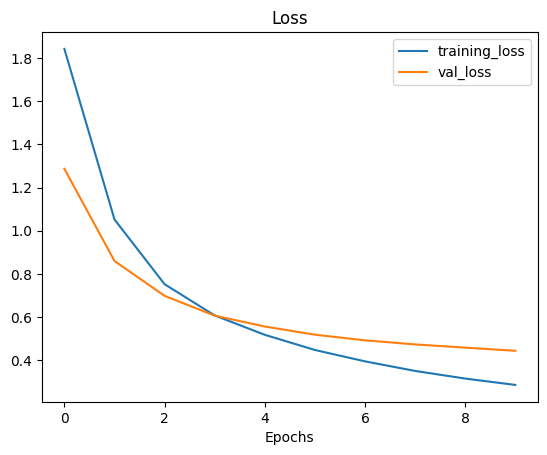

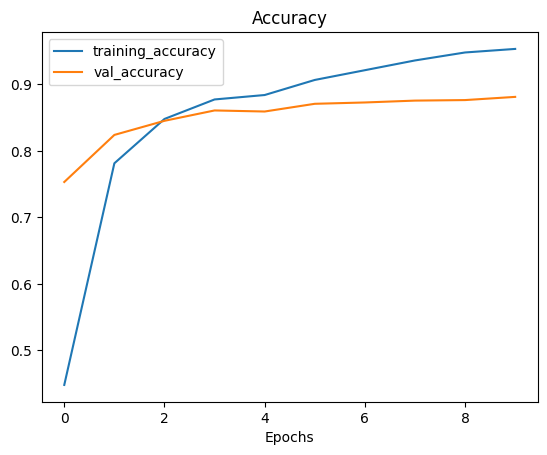

In [16]:
plot_loss_curves(efficientnet_history)

# Model Summary

In [17]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


# Predicting with new image

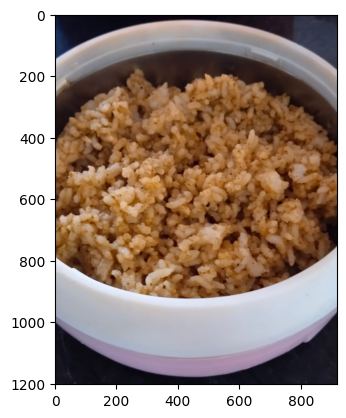

1/1 [==============================] - 0s 22ms/step
Predictions: 
[[1.54451316e-03 7.68285681e-05 9.96903598e-01 2.27009969e-05
  4.99608677e-06 5.74026126e-05 1.04058299e-05 8.01166985e-04
  1.16605195e-04 4.61797550e-04]]
Class Names: 
['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon', 'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi']

Predicted class:  fried_rice

Top three Probabilities
fried_rice 99.69 %,  chicken_curry 0.15 %,  ramen 0.08 %


In [18]:
from matplotlib.image import imread
from matplotlib import pyplot as plt

import os
import cv2
import numpy as np

image = imread('/content/friedrice_1.png')
plt.imshow(image)
plt.show()

resized_image = cv2.resize(image, (224, 224))
reshaped = resized_image.reshape(1, 224, 224, 3)

prediction = resnet_model.predict(reshaped)
print("Predictions: ")
print(prediction)

#predicted_digit = np.argmax(prediction, axis = 1)
#print("Predicted digit:", predicted_digit[0])

class_names = list(test_data.class_indices.keys()) # Access class names from the ImageDataGenerator
print("Class Names: ")
print(class_names)

# Printing the predicted class for the input food item
print("")
print("Predicted class: ", class_names[np.argmax(prediction)])

# Identifying indices of top 3 matches
x_list = np.argsort(prediction)[::-1][:3]
#print("Indices:", x_list)
x = np.array(x_list)
len_x = 10  # numner of classes

max_1 = x[0][len_x-1]
max_2 = x[0][len_x-2]
max_3 = x[0][len_x-3]

# Printing top three probabilities
print("")
print("Top three Probabilities")
print(class_names[max_1], f"{(prediction[0][max_1]*100):.2f}", "%"  ", ", class_names[max_2],
 f"{(prediction[0][max_2]*100):.2f}", "%" ", ", class_names[max_3], f"{(prediction[0][max_3]*100):.2f}", "%")

# Comparing models

In [21]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot

# Listing experiments saved to TensorBoard
#tensorboard dev list

# Delete an experiment
!tensorboard dev delete --experiment_id n6kd8XZ3Rdy1jSgSLH5WjA

2024-06-08 02:15:46.054108: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-08 02:15:46.054165: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-08 02:15:46.055762: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-08 02:15:47.596818: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
****************************************************************
****************************************************************
****************************************************************

Uploading TensorBoard logs to https://tensorb